# Visualizing Performance Summary for Cell Health Target Variables

**Gregory Way, 2019**

For both binary and regression models.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggrepel))

## Load Data

In [2]:
results_dir <- "results"

In [3]:
# Regression Results
regression_file <- file.path(results_dir, "full_cell_health_regression_results.tsv.gz")
regression_metrics_df <- readr::read_tsv(regression_file, col_types = readr::cols())

# Classification Results
roc_file <- file.path(results_dir, "full_cell_health_roc_results.tsv.gz")
full_roc_df <- readr::read_tsv(roc_file, col_types = readr::cols())

pr_file <- file.path(results_dir, "full_cell_health_pr_results.tsv.gz")
full_pr_df <- readr::read_tsv(pr_file, col_types = readr::cols())

# Model Coefficients
coef_file <- file.path(results_dir, "full_cell_health_coefficients.tsv.gz")
full_coef_df <- readr::read_tsv(coef_file, col_types = readr::cols()) %>%
    dplyr::filter(y_transform %in% c("raw", "zero-one"))

# Model Predictions
y_file <- file.path(results_dir, "full_cell_health_y_labels.tsv.gz")
y_df <- readr::read_tsv(y_file, col_types = readr::cols()) %>%
    dplyr::filter(y_transform %in% c("raw", "zero-one"))

# Annotated Cell Health Features
feat_file <- file.path("..", "0.generate-profiles", "data", "labels", "feature_mapping_annotated.csv")
label_df <- readr::read_csv(feat_file, col_types = readr::cols())

## Process Data

In [4]:
regression_subset_df <- regression_metrics_df %>%
    dplyr::filter(y_transform == "raw",
                  data_fit == "test",
                  shuffle == "shuffle_false") %>%
    tidyr::spread(key = "metric", value = "mse") %>%
    dplyr::select(-y_transform)

print(dim(regression_subset_df))
head(regression_subset_df, 3)

[1] 70  5


target,data_fit,shuffle,mse,r_two
<chr>,<chr>,<chr>,<dbl>,<dbl>
cc_all_high_n_spots_h2ax_mean,test,shuffle_false,0.3856605,0.04190731
cc_all_large_notround_polynuclear_mean,test,shuffle_false,0.4212374,0.57684490
cc_all_large_round_polyploid_mean,test,shuffle_false,0.2789179,0.58502930


In [5]:
auroc_df <- full_roc_df %>%
    dplyr::distinct(metric, target, auc, data_fit,
                    shuffle, y_transform, min_class_count)

aupr_df <- full_pr_df %>%
    dplyr::distinct(metric, target, auc, data_fit,
                    shuffle, y_transform, min_class_count)

auc_df <- dplyr::bind_rows(auroc_df, aupr_df) %>%
    dplyr::filter(shuffle == "shuffle_false")

auc_df$metric <- dplyr::recode_factor(
    auc_df$metric,
    "roc" = "AUROC",
    "aupr" = "AUPR"
)

auc_df <- auc_df %>%
    tidyr::spread(key = "metric", value = "auc") %>%
    dplyr::select(-y_transform)

test_auc_df <- auc_df %>%
    dplyr::filter(data_fit == "test")

train_auc_df <- auc_df %>%
    dplyr::filter(data_fit == "train") %>%
    dplyr::select(-data_fit)

auc_df <- train_auc_df %>%
    dplyr::full_join(test_auc_df,
                     by = c("target", "shuffle", "min_class_count"),
                     suffix = c("_train", "_test"))

print(dim(auc_df))
head(auc_df, 2)

Warning message:
“The `printer` argument is deprecated as of rlang 0.3.0.
This warning is displayed once per session.”Warning message:
“`chr_along()` is deprecated as of rlang 0.2.0.
This warning is displayed once per session.”

[1] 68  8


target,shuffle,min_class_count,AUROC_train,AUPR_train,data_fit,AUROC_test,AUPR_test
<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
cc_all_high_n_spots_h2ax_mean,shuffle_false,151,0.7696497,0.8026890,test,0.6995885,0.7281552
cc_all_large_notround_polynuclear_mean,shuffle_false,151,0.8711659,0.8715625,test,0.6035665,0.5912571


In [6]:
metric_df <- regression_subset_df %>%
    dplyr::inner_join(auc_df, by = c("target", "data_fit", "shuffle")) %>%
    dplyr::left_join(label_df, by = c("target" = "updated_name"))

metric_df$mse = abs(metric_df$mse)

metric_df$maria_thumbs_up <- tidyr::replace_na(metric_df$maria_thumbs_up, 0)
metric_df$measurement <- tidyr::replace_na(metric_df$measurement, "other")

metric_df$measurement <- factor(metric_df$measurement,
                                levels = c("apoptosis",
                                           "death",
                                           "cell_viability",
                                           "toxicity",
                                           "dna_damage",
                                           "cell_cycle_arrest",
                                           "g1_arrest",
                                           "g2_arrest",
                                           "g2_m_arrest",
                                           "s_arrest",
                                           "other"))

metric_df$assay <- factor(metric_df$assay,
                          levels = c("hoechst",
                                     "edu",
                                     "gh2ax",
                                     "ph3",
                                     "hoechst_gh2ax",
                                     "hoechst_edu",
                                     "edu_gh2ax",
                                     "caspase",
                                     "draq",
                                     "draq_caspase",
                                     "many_cell_cycle",
                                     "crispr_efficiency"))
print(dim(metric_df))
head(metric_df, 3)

[1] 68 16


target,data_fit,shuffle,mse,r_two,min_class_count,AUROC_train,AUPR_train,AUROC_test,AUPR_test,original_name,feature_type,measurement,maria_thumbs_up,assay,description
<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<dbl>,<fct>,<chr>
cc_all_high_n_spots_h2ax_mean,test,shuffle_false,0.3856605,0.04190731,151,0.7696497,0.8026890,0.6995885,0.7281552,ALL - High number of spots gH2AX - Mean per Well,cell_cycle,dna_damage,0,gh2ax,Within all cells: fraction of cells containing more than 3 gH2AX spots
cc_all_large_notround_polynuclear_mean,test,shuffle_false,0.4212374,0.57684490,151,0.8711659,0.8715625,0.6035665,0.5912571,ALL - large not round (polynuclear) - Mean per Well,cell_cycle,toxicity,0,hoechst,Fraction of cells with large non-round nuclei
cc_all_large_round_polyploid_mean,test,shuffle_false,0.2789179,0.58502930,151,0.9810038,0.9844315,0.5843621,0.6815364,ALL - Large round (polyploid) - Mean per Well,cell_cycle,other,0,hoechst,NA


## Plot Performance

In [7]:
# Set some plotting defaults
measurement_colors <- c(
    "apoptosis" = "#a6cee3",
    "cell_cycle_arrest" = "#1f78b4",
    "cell_viability" = "#b2df8a",
    "death" = "#33a02c",
    "dna_damage" = "#fb9a99", 
    "g1_arrest" = "#fdbf6f",
    "g2_arrest" = "#ff7f00",
    "g2_m_arrest" = "#005c8c",
    "other" = "black",
    "s_arrest" = "#cab2d6",
    "toxicity" = "#6a3d9a"
)

measurement_labels <- c(
    "apoptosis" = "Apoptosis",
    "cell_cycle_arrest" = "Cell Cycle Arrest",
    "cell_viability" = "Cell Viability",
    "death" = "Death",
    "dna_damage" = "DNA Damage", 
    "g1_arrest" = "G1 Arrest",
    "g2_arrest" = "G2 Arrest",
    "g2_m_arrest" = "G2/M Arrest",
    "other" = "Other",
    "s_arrest" = "S Arrest",
    "toxicity" = "Toxicity"
)

dye_colors <- c(
    "hoechst" = "#639B94",
    "edu" = "#E45242",
    "gh2ax" = "#E2C552",
    "ph3" = "#7B9C32",
    "hoechst_gh2ax" = "#535f52",
    "hoechst_edu" = "#73414b",
    "edu_gh2ax" = "#e37a48",
    "caspase" = "#F7B1C1",
    "draq" = "#FF6699",
    "draq_caspase" = "#7f4a72",
    "many_cell_cycle" = "#E9DFC3",
    "crispr_efficiency" = "black"
)

dye_labels <- c(
    "hoechst" = "Hoechst",
    "edu" = "EdU",
    "gh2ax" = "gH2AX",
    "ph3" = "pH3",
    "hoechst_gh2ax" = "Hoechst + gH2AX",
    "hoechst_edu" = "Hoechst + EdU",
    "edu_gh2ax" = "EdU + gH2AX",
    "caspase" = "Caspase 3/7",
    "draq" = "DRAQ7",
    "draq_caspase" = "DRAQ7 + Caspase 3/7",
    "many_cell_cycle" = "Cell Cycle (Many Dyes)",
    "crispr_efficiency" = "CRISPR Efficiency"
)

Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

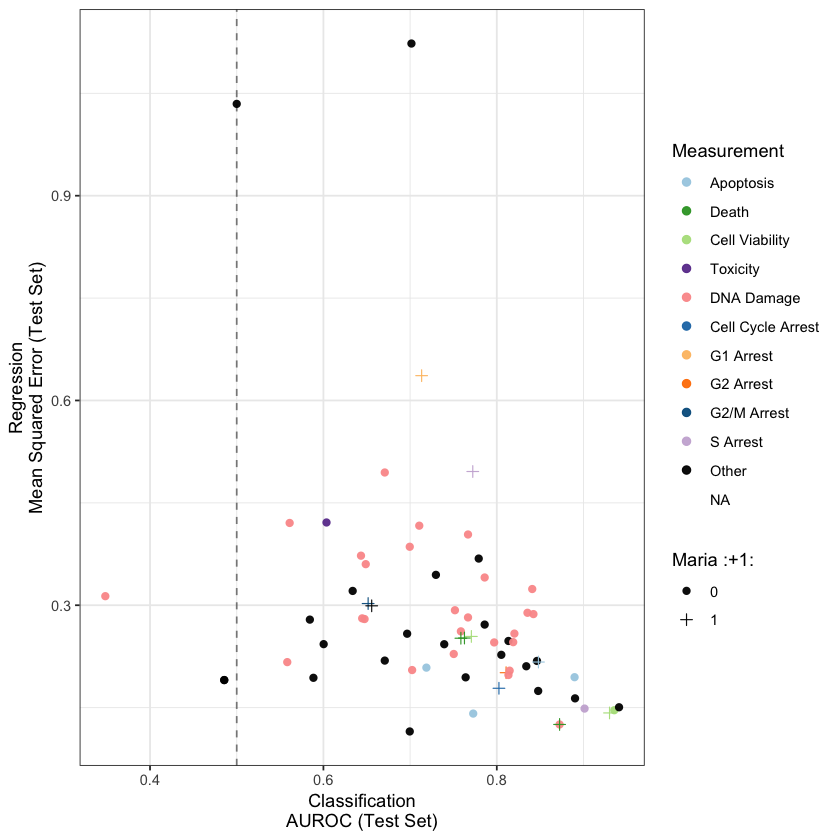

In [8]:
ggplot(metric_df, aes(x = AUROC_test, y = mse)) +
    geom_point(alpha = 0.95,
               size = 2,
               aes(color = measurement,
                   shape = as.factor(maria_thumbs_up))) +
    xlab("Classification\nAUROC (Test Set)") +
    ylab("Regression\nMean Squared Error (Test Set)") +
    geom_vline(xintercept = 0.5,
               alpha = 0.5, 
               linetype = "dashed") +
    scale_shape_manual(name = "Maria :+1:",
                       values = c(16, 3)) +
    scale_color_manual(name = "Measurement",
                       values = measurement_colors,
                       labels = measurement_labels) +
    theme_bw()

file <- file.path("figures", "performance_summary.png")
ggsave(file, dpi = 300, width = 6, height = 4.25)

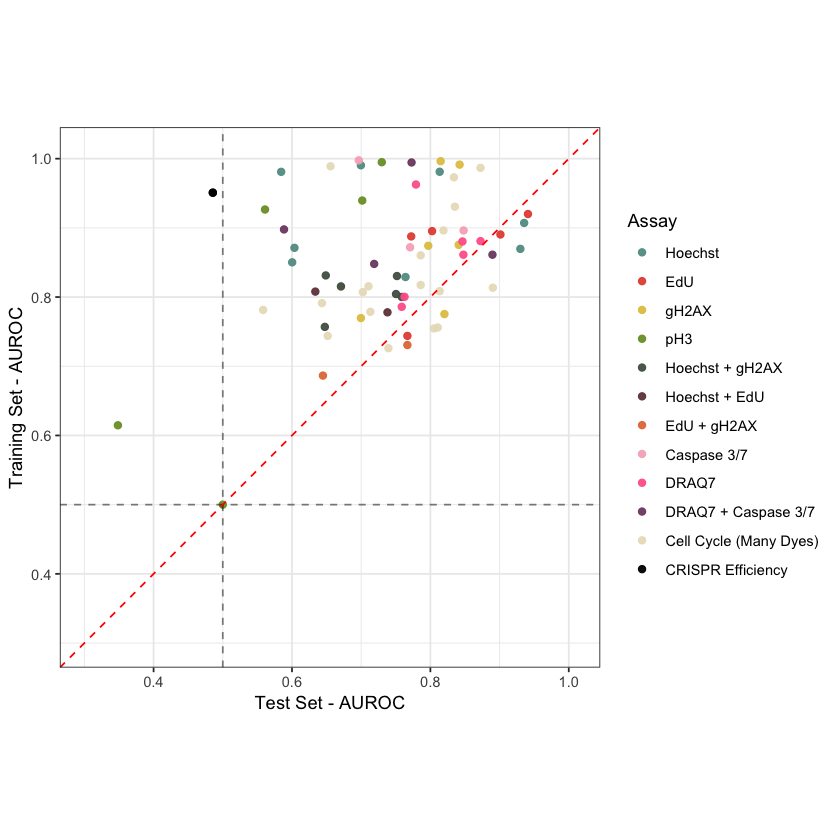

In [9]:
ggplot(metric_df, aes(x = AUROC_test, y = AUROC_train)) +
    geom_point(alpha = 0.95,
               size = 1.7,
               aes(color = assay)) +
    xlab("Test Set - AUROC") +
    ylab("Training Set - AUROC") +
    geom_vline(xintercept = 0.5,
               alpha = 0.5, 
               linetype = "dashed") +
    geom_hline(yintercept = 0.5,
               alpha = 0.5, 
               linetype = "dashed") +
    geom_abline(slope = 1,
                intercept = 0, 
                color = "red",
                linetype = "dashed") +
    xlim(c(0.3, 1.01)) +
    ylim(c(0.3, 1.01)) +
    coord_fixed() +
    scale_color_manual(name = "Assay",
                       values = dye_colors,
                       labels = dye_labels) +
    theme_bw()

file <- file.path("figures", "performance_summary_assay.png")
ggsave(file, dpi = 300, width = 6, height = 4.5)

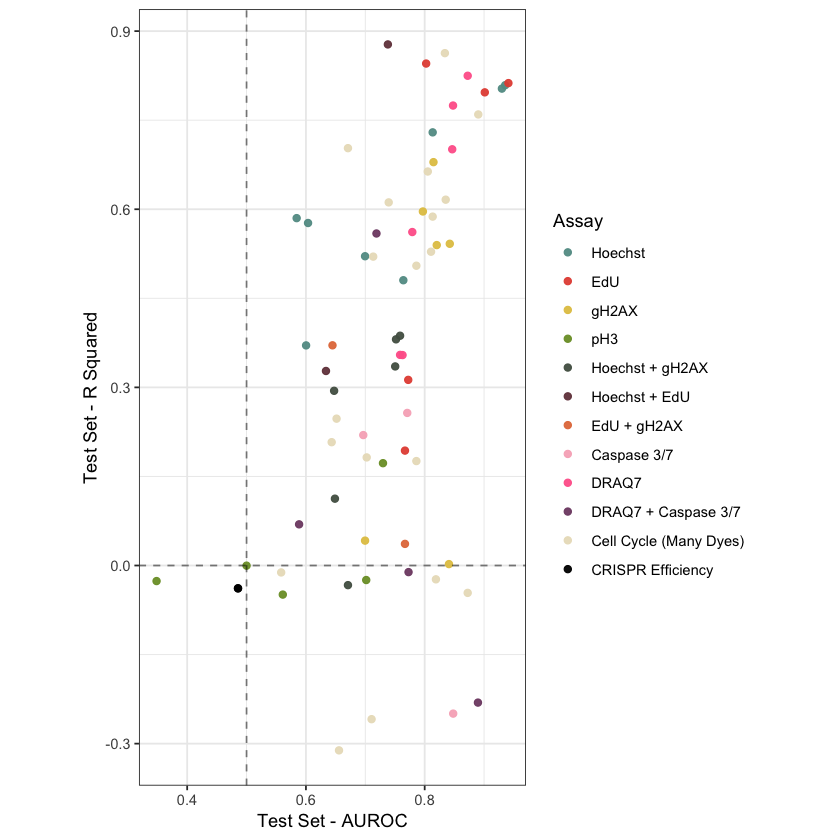

In [10]:
ggplot(metric_df, aes(x = AUROC_test,
                      y = r_two)) +
    geom_point(alpha = 0.95,
               size = 1.7,
               aes(color = assay)) +
    xlab("Test Set - AUROC") +
    ylab("Test Set - R Squared") +
    geom_vline(xintercept = 0.5,
               alpha = 0.5, 
               linetype = "dashed") +
    geom_hline(yintercept = 0,
               alpha = 0.5, 
               linetype = "dashed") +
    coord_fixed() +
    scale_color_manual(name = "Assay",
                       values = dye_colors,
                       labels = dye_labels) +
    theme_bw()

file <- file.path("figures", "performance_summary_assay_classification_vs_regression.png")
ggsave(file, dpi = 300, width = 6, height = 4.5)

## Separate Training and Testing Regression Metrics

In [11]:
r_two_df <- regression_metrics_df %>%
    dplyr::filter(metric == "r_two",
                  shuffle == "shuffle_false",
                  y_transform == "raw") %>%
    tidyr::spread(data_fit, mse) %>%
    dplyr::left_join(label_df, by=c("target" = "updated_name"))

r_two_df$measurement <- tidyr::replace_na(r_two_df$measurement, "other")
r_two_df$measurement <- factor(r_two_df$measurement,
                               levels = c("apoptosis",
                                          "death",
                                          "cell_viability",
                                          "toxicity",
                                          "dna_damage",
                                          "cell_cycle_arrest",
                                          "g1_arrest",
                                          "g2_arrest",
                                          "g2_m_arrest",
                                          "s_arrest",
                                          "other"))

r_two_df$assay <- factor(r_two_df$assay,
                          levels = c("hoechst",
                                     "edu",
                                     "gh2ax",
                                     "ph3",
                                     "hoechst_gh2ax",
                                     "hoechst_edu",
                                     "edu_gh2ax",
                                     "caspase",
                                     "draq",
                                     "draq_caspase",
                                     "many_cell_cycle",
                                     "crispr_efficiency"))
print(dim(r_two_df))
head(r_two_df, 2)

[1] 70 12


metric,target,shuffle,y_transform,test,train,original_name,feature_type,measurement,maria_thumbs_up,assay,description
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<int>,<fct>,<chr>
r_two,cc_all_high_n_spots_h2ax_mean,shuffle_false,raw,0.04190731,0.5890412,ALL - High number of spots gH2AX - Mean per Well,cell_cycle,dna_damage,0,gh2ax,Within all cells: fraction of cells containing more than 3 gH2AX spots
r_two,cc_all_large_notround_polynuclear_mean,shuffle_false,raw,0.57684490,0.5014090,ALL - large not round (polynuclear) - Mean per Well,cell_cycle,toxicity,0,hoechst,Fraction of cells with large non-round nuclei


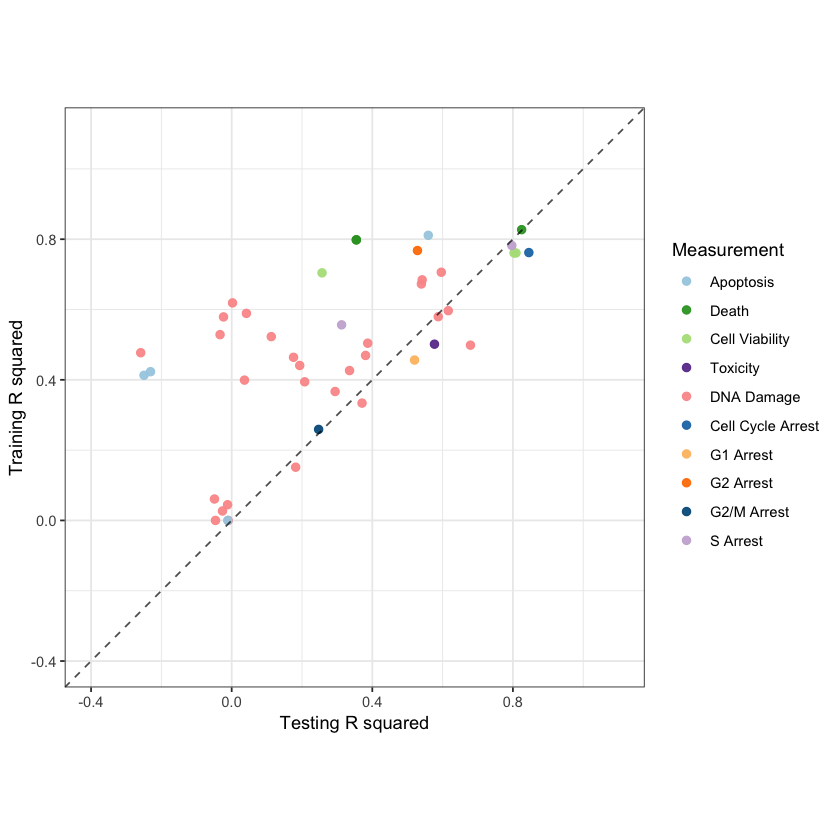

In [12]:
ggplot(r_two_df %>%
       dplyr::filter(measurement != "other"),
       aes(y = train, x = test)) +
    geom_point(alpha = 0.95,
               size = 2,
               aes(color = measurement)) +
    coord_fixed() +
    ylab("Training R squared") +
    xlab("Testing R squared") +
    geom_abline(intercept = 0,
            slope = 1,
            linetype = "dashed",
            color = "black",
            alpha = 0.7) +
    xlim(c(-0.4, 1.1)) +
    ylim(c(-0.4, 1.1)) +
    scale_color_manual(name = "Measurement",
                       values = measurement_colors,
                       labels = measurement_labels) +
    theme_bw()

file <- file.path("figures", "performance_summary_rsquared.png")
ggsave(file, dpi = 300, width = 6, height = 4.25)

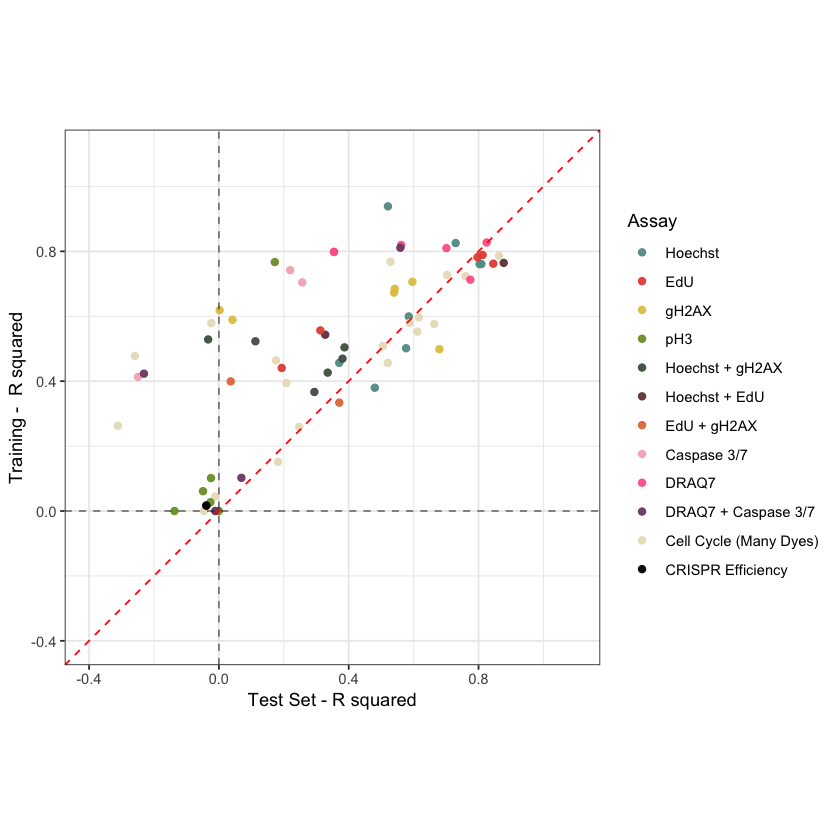

In [13]:
ggplot(r_two_df, aes(y = train, x = test)) +
    geom_point(alpha = 0.95,
               size = 1.7,
               aes(color = assay)) +
    ylab("Training -  R squared") +
    xlab("Test Set - R squared") +
    geom_vline(xintercept = 0,
               alpha = 0.5, 
               linetype = "dashed") +
    geom_hline(yintercept = 0,
               alpha = 0.5, 
               linetype = "dashed") +
    geom_abline(slope = 1,
                intercept = 0, 
                color = "red",
                linetype = "dashed") +
    xlim(c(-0.4, 1.1)) +
    ylim(c(-0.4, 1.1)) +
    coord_fixed() +
    scale_color_manual(name = "Assay",
                       values = dye_colors,
                       labels = dye_labels) +
    theme_bw()

file <- file.path("figures", "performance_summary_rsquared_assay.png")
ggsave(file, dpi = 300, width = 6, height = 4.25)

## Compare cytominer with pycytominer

### Regression Results

In [14]:
# Cytominer results are archived on github
hash = "26d1095c209d402102494c0c28e978476643e572"
cyto_file = paste0("https://github.com/broadinstitute/cell-health/raw/",
                   hash, "/3.train/results/full_cell_health_regression_results.tsv.gz")

cyto_regression_df = readr::read_tsv(cyto_file, col_types=readr::cols()) %>%
    dplyr::mutate(package = "cytominer")

head(cyto_regression_df, 2)

mse,metric,target,data_fit,shuffle,y_transform,package
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
0.6590045,mse,cc_all_high_n_spots_h2ax_mean,train,shuffle_true,raw,cytominer
0.4247787,mse,cc_all_high_n_spots_h2ax_mean,test,shuffle_true,raw,cytominer


In [15]:
regression_metrics_df <- regression_metrics_df %>%
    dplyr::mutate(package = "pycytominer")

head(regression_metrics_df, 2)

mse,metric,target,data_fit,shuffle,y_transform,package
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
0.6021278,mse,cc_all_high_n_spots_h2ax_mean,train,shuffle_true,raw,pycytominer
0.3902642,mse,cc_all_high_n_spots_h2ax_mean,test,shuffle_true,raw,pycytominer


In [16]:
all_regression_df <- regression_metrics_df %>%
    dplyr::inner_join(cyto_regression_df,
                      by = c("metric", "target", "data_fit", "shuffle", "y_transform"),
                      suffix = c("_pycytominer", "_cytominer")) %>%
    dplyr::mutate(mse_diff = mse_pycytominer - mse_cytominer)

head(all_regression_df, 2)

mse_pycytominer,metric,target,data_fit,shuffle,y_transform,package_pycytominer,mse_cytominer,package_cytominer,mse_diff
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
0.6021278,mse,cc_all_high_n_spots_h2ax_mean,train,shuffle_true,raw,pycytominer,0.6590045,cytominer,-0.05687664
0.3902642,mse,cc_all_high_n_spots_h2ax_mean,test,shuffle_true,raw,pycytominer,0.4247787,cytominer,-0.03451457


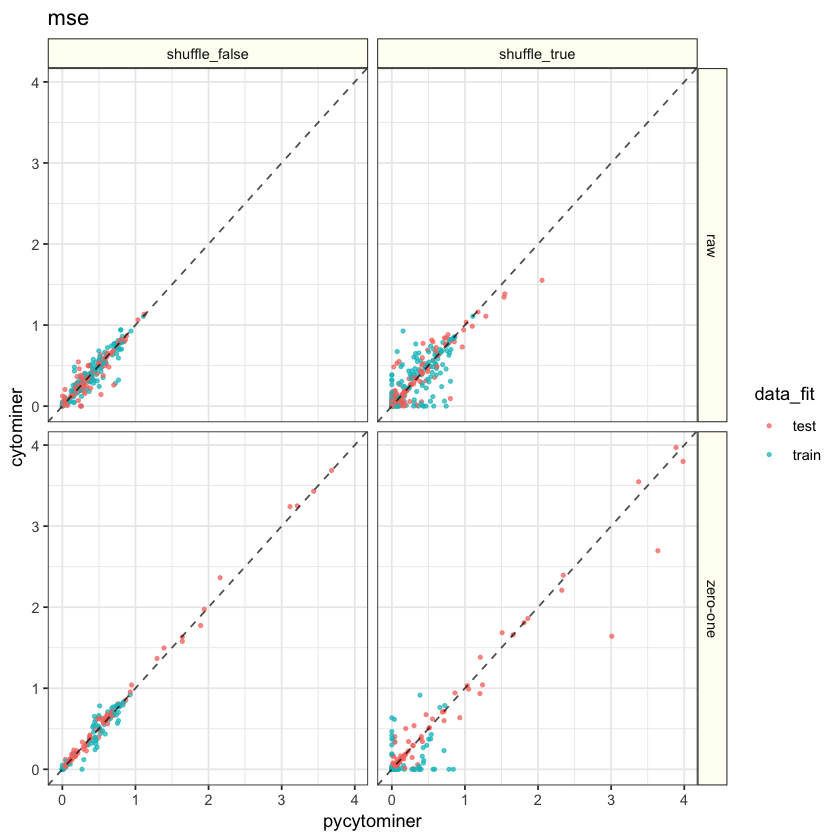

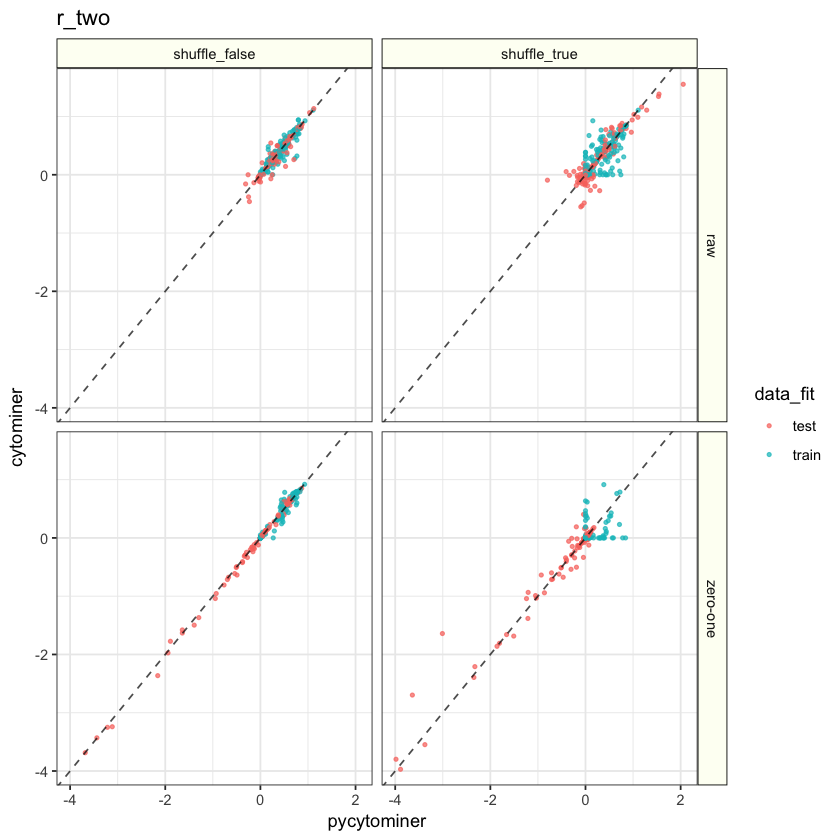

In [17]:
for (metric in unique(all_regression_df$metric)) {
    all_regression_subset_df <- all_regression_df %>%
        dplyr::filter(metric == metric)
    
    if (metric == "mse") {
        all_regression_subset_df$mse_pycytominer <- abs(all_regression_subset_df$mse_pycytominer)
        all_regression_subset_df$mse_cytominer <- abs(all_regression_subset_df$mse_cytominer)
    }
    
    mse_gg <- ggplot(all_regression_subset_df,
       aes(x=mse_pycytominer, 
           y=mse_cytominer)) +
    geom_point(aes(color = data_fit),
               alpha = 0.7,
               size = 0.8) +
    facet_grid(y_transform~shuffle) +
    xlab("pycytominer") +
    ylab("cytominer") +
    ggtitle(metric) +
    geom_abline(intercept = 0,
                slope = 1,
                linetype = "dashed",
                color = "black",
                alpha = 0.7) +
    theme_bw() +
    theme(strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))
    
    print(mse_gg)
    outfile <- file.path("figures", paste0("compare_pycytominer_cytominer_", metric, ".png"))
    ggsave(outfile, height = 5, width = 6, dpi = 300)
}



In [18]:
all_regression_df %>%
    dplyr::group_by(metric, data_fit, shuffle, y_transform) %>%
    dplyr::mutate(percent_pycytominer_better = sum(mse_diff > 0) / n()) %>%
    dplyr::distinct(metric, data_fit, shuffle, y_transform, percent_pycytominer_better)

metric,data_fit,shuffle,y_transform,percent_pycytominer_better
<chr>,<chr>,<chr>,<chr>,<dbl>
mse,train,shuffle_true,raw,0.3285714
mse,test,shuffle_true,raw,0.3857143
r_two,train,shuffle_true,raw,0.5142857
r_two,test,shuffle_true,raw,0.4571429
mse,train,shuffle_false,raw,0.4000000
mse,test,shuffle_false,raw,0.3714286
r_two,train,shuffle_false,raw,0.5714286
r_two,test,shuffle_false,raw,0.6000000
mse,train,shuffle_true,zero-one,0.2571429


### Classification Comparison

In [19]:
# Cytominer results are archived on github
cyto_file = paste0("https://github.com/broadinstitute/cell-health/raw/",
                   hash, "/3.train/results/full_cell_health_roc_results.tsv.gz")

cyto_roc_df = readr::read_tsv(cyto_file, col_types=readr::cols())

head(cyto_roc_df, 2)

fpr,tpr,threshold,metric,target,auc,data_fit,shuffle,y_transform,min_class_count
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<int>
0,0.000000000,8.538085,roc,cc_all_high_n_spots_h2ax_mean,0.9018822,train,shuffle_true,binarize,151
0,0.006578947,7.538085,roc,cc_all_high_n_spots_h2ax_mean,0.9018822,train,shuffle_true,binarize,151


In [20]:
cyto_file = paste0("https://github.com/broadinstitute/cell-health/raw/",
                   hash, "/3.train/results/full_cell_health_pr_results.tsv.gz")

cyto_pr_df = readr::read_tsv(cyto_file, col_types=readr::cols())

head(cyto_pr_df, 2)

precision,recall,threshold,metric,target,auc,data_fit,shuffle,y_transform,min_class_count
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<int>
0.5779468,1.0000000,-0.8279075,aupr,cc_all_high_n_spots_h2ax_mean,0.9145002,train,shuffle_true,binarize,151
0.5763359,0.9934211,-0.8254211,aupr,cc_all_high_n_spots_h2ax_mean,0.9145002,train,shuffle_true,binarize,151


In [21]:
cyto_auroc_df <- cyto_roc_df %>%
    dplyr::distinct(metric, target, auc, data_fit,
                    shuffle, y_transform, min_class_count)

cyto_aupr_df <- cyto_pr_df %>%
    dplyr::distinct(metric, target, auc, data_fit,
                    shuffle, y_transform, min_class_count)

cyto_auc_df <- dplyr::bind_rows(cyto_auroc_df, cyto_aupr_df) %>%
    dplyr::filter(shuffle == "shuffle_false",
                  data_fit == "test")

cyto_auc_df$metric <- dplyr::recode_factor(
    cyto_auc_df$metric,
    "roc" = "AUROC",
    "aupr" = "AUPR"
)

cyto_auc_df <- cyto_auc_df %>%
    tidyr::spread(key = "metric", value = "auc") %>%
    dplyr::select(-y_transform) %>%
    dplyr::mutate(package = "pycytominer")

print(dim(cyto_auc_df))
head(cyto_auc_df, 2)

[1] 68  7


target,data_fit,shuffle,min_class_count,AUROC,AUPR,package
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>
cc_all_high_n_spots_h2ax_mean,test,shuffle_false,151,0.7750343,0.7919861,pycytominer
cc_all_large_notround_polynuclear_mean,test,shuffle_false,151,0.5226337,0.5404478,pycytominer


In [22]:
auc_df <- auc_df %>%
    dplyr::mutate(package = "cytominer")

In [23]:
all_classification_df <- auc_df %>%
    dplyr::inner_join(cyto_auc_df,
                      by = c("target", "data_fit", "shuffle", "min_class_count"),
                      suffix = c("_pycytominer", "_cytominer")) %>%
    dplyr::mutate(auroc_diff = AUROC - AUROC_test,
                  aupr_diff = AUPR - AUPR_test) %>%
    dplyr::filter(data_fit == "test",
                  shuffle == "shuffle_false") 

head(all_classification_df, 2)

target,shuffle,min_class_count,AUROC_train,AUPR_train,data_fit,AUROC_test,AUPR_test,package_pycytominer,AUROC,AUPR,package_cytominer,auroc_diff,aupr_diff
<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
cc_all_high_n_spots_h2ax_mean,shuffle_false,151,0.7696497,0.8026890,test,0.6995885,0.7281552,cytominer,0.7750343,0.7919861,pycytominer,0.07544582,0.06383095
cc_all_large_notround_polynuclear_mean,shuffle_false,151,0.8711659,0.8715625,test,0.6035665,0.5912571,cytominer,0.5226337,0.5404478,pycytominer,-0.08093278,-0.05080930


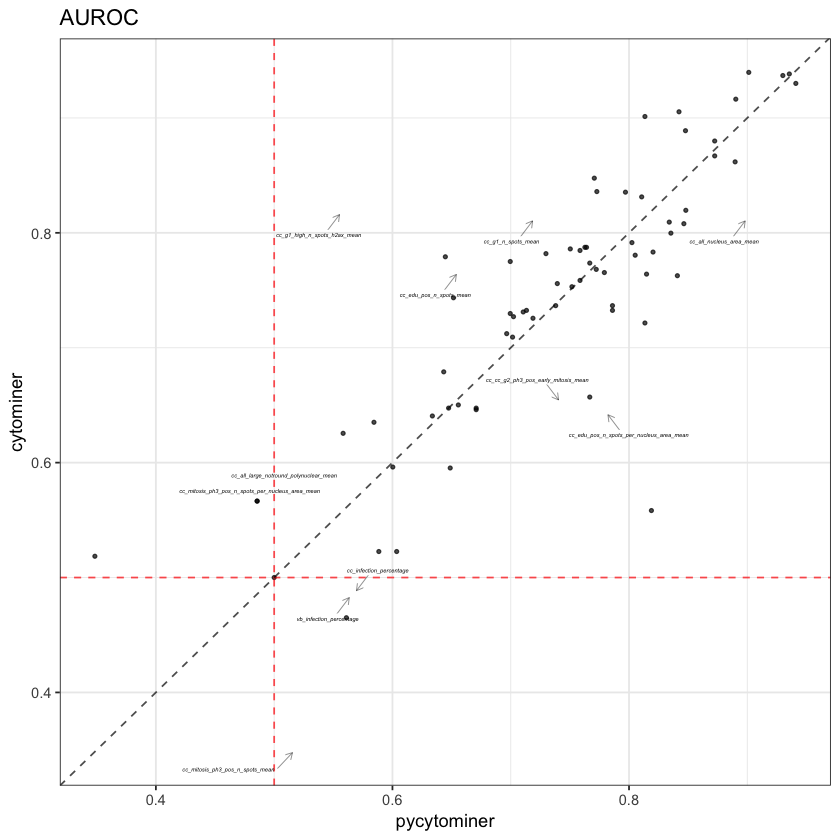

In [24]:
metric <- "AUROC"

label_logic <- abs(all_classification_df$auroc_diff) > 0.08

ggplot(all_classification_df,
       aes(x=AUROC_test, 
           y=AUROC)) +
    geom_point(alpha = 0.7,
               size = 0.8) +
    xlab("pycytominer") +
    ylab("cytominer") +
    geom_hline(yintercept = 0.5,
               linetype = "dashed",
               color = "red",
               alpha = 0.7) +
    geom_vline(xintercept = 0.5,
               linetype = "dashed",
               color = "red",
               alpha = 0.7) +
    geom_abline(intercept = 0,
                slope = 1,
                linetype = "dashed",
                color = "black",
                alpha = 0.7) +
    ggtitle(metric) +
    geom_text_repel(data = subset(all_classification_df, label_logic),
                    arrow = arrow(length = unit(0.01, "npc")),
                    box.padding = 0.6,
                    point.padding = 0.3,
                    segment.size = 0.2,
                    segment.alpha = 0.6,
                    size = 1.2,
                    fontface = "italic",
                    aes(label = target,
                        x = AUROC,
                        y = AUROC_test)) +
    theme_bw()

outfile <- file.path("figures", paste0("compare_pycytominer_cytominer_", metric, ".png"))
ggsave(outfile, height = 3, width = 3, dpi = 300)

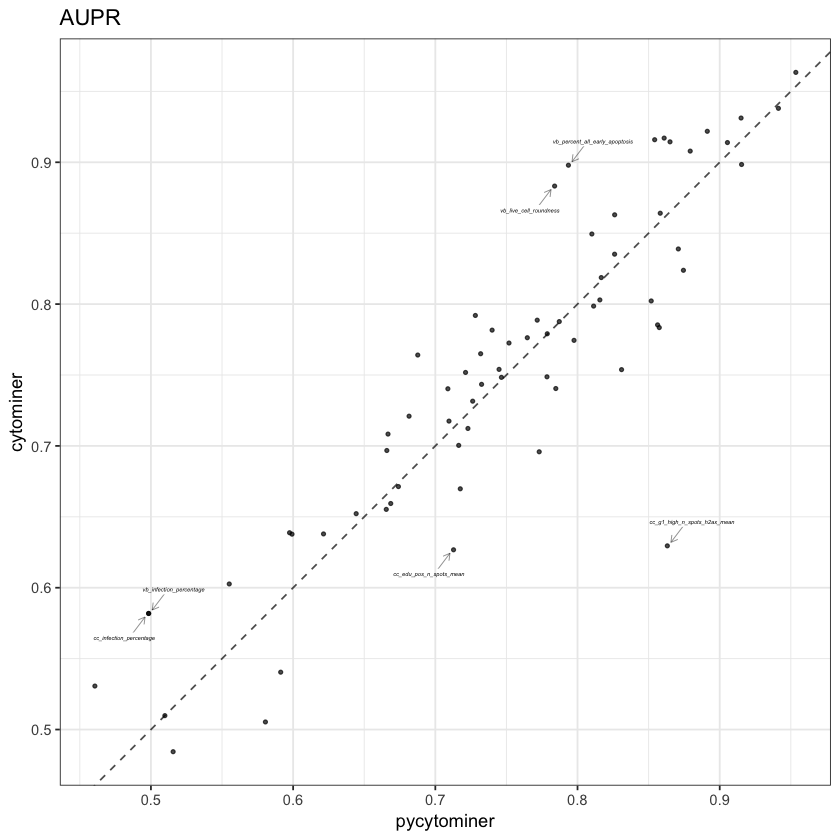

In [25]:
metric <- "AUPR"

label_logic <- abs(all_classification_df$aupr_diff) > 0.08

ggplot(all_classification_df,
       aes(x=AUPR_test, 
           y=AUPR)) +
    geom_point(alpha = 0.7,
               size = 0.8) +
    xlab("pycytominer") +
    ylab("cytominer") +
    geom_abline(intercept = 0,
                slope = 1,
                linetype = "dashed",
                color = "black",
                alpha = 0.7) +
    ggtitle(metric) +
    geom_text_repel(data = subset(all_classification_df, label_logic),
                        arrow = arrow(length = unit(0.01, "npc")),
                        box.padding = 0.6,
                        point.padding = 0.3,
                        segment.size = 0.2,
                        segment.alpha = 0.6,
                        size = 1.2,
                        fontface = "italic",
                        aes(label = target,
                            x = AUPR_test,
                            y = AUPR)) +
    theme_bw()

outfile <- file.path("figures", paste0("compare_pycytominer_cytominer_", metric, ".png"))
ggsave(outfile, height = 3, width = 3, dpi = 300)

In [26]:
all_classification_df %>%
    dplyr::mutate(percent_auroc_pycytominer_better = sum(auroc_diff > 0) / n(),
                  percent_aupr_pycytominer_better = sum(aupr_diff > 0) / n()) %>%
    dplyr::distinct(data_fit, shuffle, percent_auroc_pycytominer_better, percent_aupr_pycytominer_better)

shuffle,data_fit,percent_auroc_pycytominer_better,percent_aupr_pycytominer_better
<chr>,<chr>,<dbl>,<dbl>
shuffle_false,test,0.5441176,0.6176471
